# Example Calculation of the Load Differences Between a Pair of Scenarios


In [8]:
# Start by importing the packages we need:
import os

import pandas as pd
import matplotlib.pyplot as plt


## Set the Directory Structure

In [9]:
# Identify the data input and image output directories:
data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/outputs/tell_output/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2023_applied_energy/figures/'


## Process the Data


In [13]:
# Read in the state-level time series for 'rcp85hotter_ssp5':
df_one = pd.read_csv(data_input_dir + 'rcp85hotter_ssp5/2080/TELL_Balancing_Authority_Hourly_Load_Data_2080_Scaled_2080.csv')

# Rename a few columns for simplicity:
df_one.rename(columns={'Scaled_TELL_BA_Load_MWh': 'Load_One_MWh'}, inplace=True)

# Only keep the columns that are needed:
df_one = df_one[['BA_Code', 'Time_UTC', 'Load_One_MWh']].copy()

# Read in the state-level time series for 'rcp45hotter_ssp5':
df_two = pd.read_csv(data_input_dir + 'rcp45hotter_ssp5/2080/TELL_Balancing_Authority_Hourly_Load_Data_2080_Scaled_2080.csv')
            
# Rename a few columns for simplicity:
df_two.rename(columns={'Scaled_TELL_BA_Load_MWh': 'Load_Two_MWh'}, inplace=True)
       
# Only keep the columns that are needed:
df_two = df_two[['BA_Code', 'Time_UTC', 'Load_Two_MWh']].copy()
        
# Merge the two time series together on state name and time:
merged_df = df_one.merge(df_two, on=['BA_Code', 'Time_UTC'])
            
# Calculate the mean load between the two time-series as well as the absolute and relative load biases:
merged_df['Mean_Load_MWh'] =  merged_df[['Load_One_MWh', 'Load_Two_MWh']].mean(axis=1)
merged_df['Absolute_Difference_MWh'] = abs(merged_df['Load_One_MWh'] - merged_df['Load_Two_MWh'])
merged_df['Relative_Difference_%'] = 100*(merged_df['Absolute_Difference_MWh']/merged_df['Mean_Load_MWh']).round(4)

# Convert the time to a datetime variable:
merged_df['Time_UTC'] = pd.to_datetime(merged_df['Time_UTC'], format='%Y-%m-%d %H:%M:%S')

# Subset to just the data for CISO:
merged_df = merged_df[merged_df['BA_Code'] == 'CISO'].copy()

# Subset to the top 10% of all mean load hours:
peak_df = merged_df.nlargest(876,'Mean_Load_MWh')

# Compute the mean absolute and relative differences for the full dataset and peak subset:
merged_df['Mean_Abs_Diff_MWh'] = merged_df['Absolute_Difference_MWh'].mean().round(2)
merged_df['Mean_Rel_Diff_%'] = merged_df['Relative_Difference_%'].mean().round(2)
merged_df['Peak_Abs_Diff_M1_MWh'] = peak_df['Absolute_Difference_MWh'].mean().round(2)
merged_df['Peak_Rel_Diff_M1_%'] = peak_df['Relative_Difference_%'].mean().round(2)
merged_df['Peak_Abs_Diff_M2_MWh'] = (abs(merged_df['Load_One_MWh'].max() - merged_df['Load_Two_MWh'].max())).round(2)
merged_df['Peak_Rel_Diff_M2_%'] = 100*(merged_df['Peak_Abs_Diff_M2_MWh'] / ((merged_df['Load_One_MWh'].max() + merged_df['Load_Two_MWh'].max())/2)).round(2)


## Make the Plot


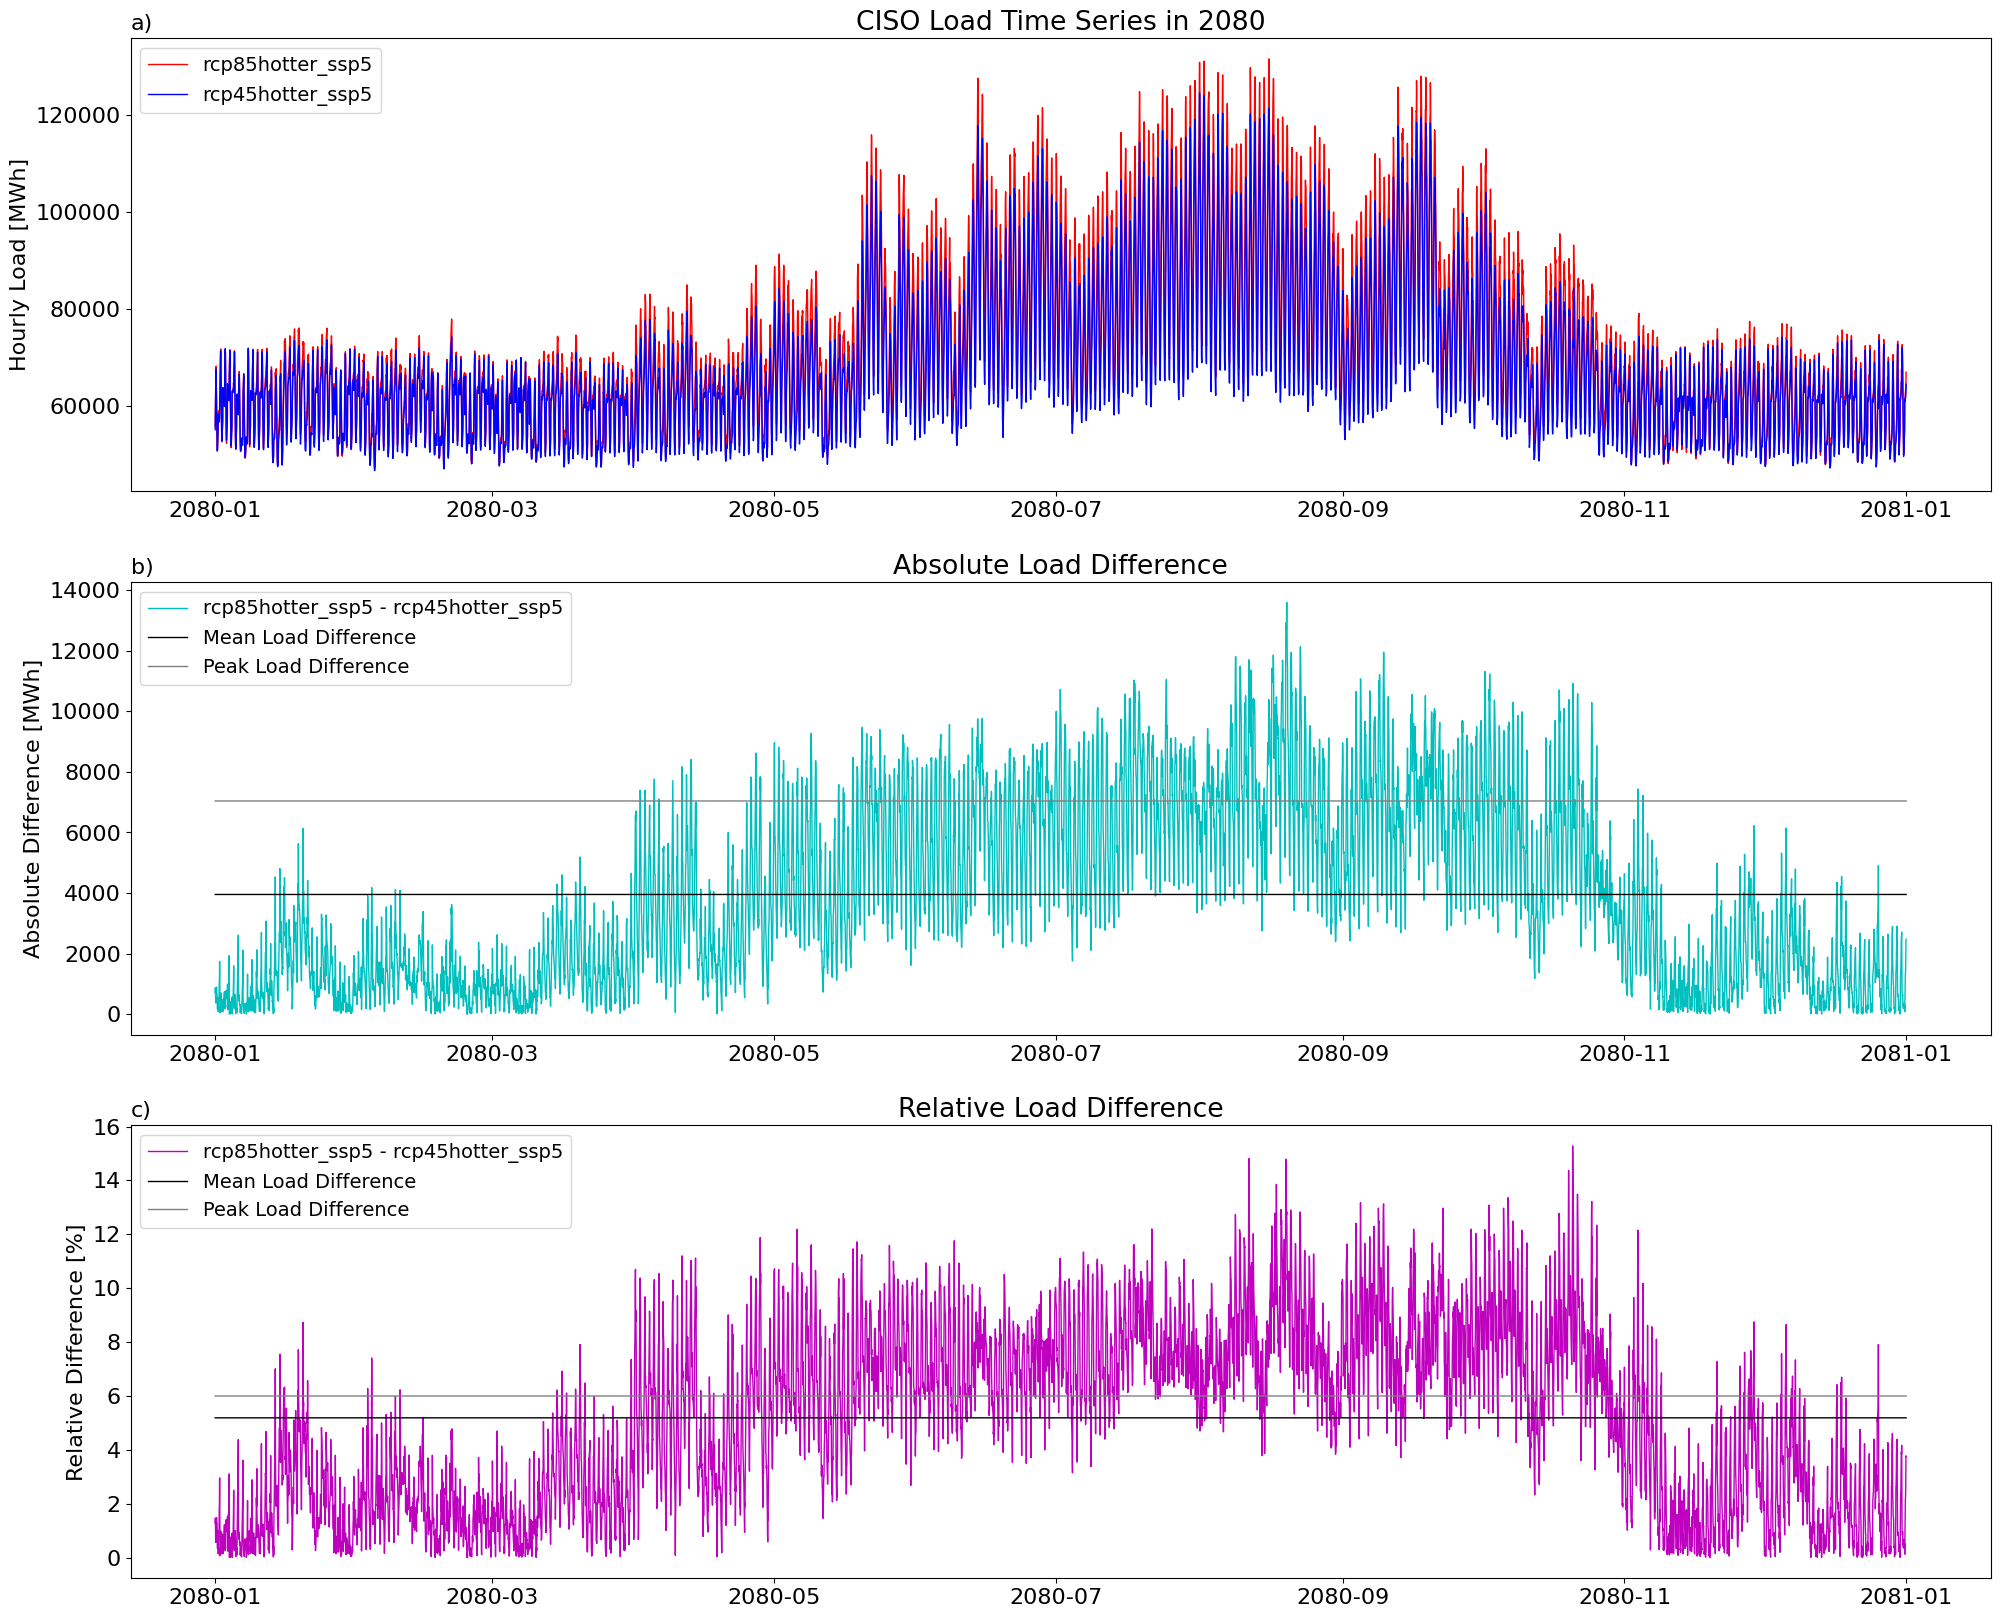

In [17]:
# Make the plot:
plt.figure(figsize=(24, 20))
plt.rcParams['font.size'] = 16
    
plt.subplot(311)
plt.plot(merged_df['Time_UTC'], merged_df['Load_One_MWh'], color='r', linestyle='-', label='rcp85hotter_ssp5', linewidth=1)
plt.plot(merged_df['Time_UTC'], merged_df['Load_Two_MWh'], color='b', linestyle='-', label='rcp45hotter_ssp5', linewidth=1)
plt.legend(loc='upper left', prop={'size': 14})
plt.xlabel('')
plt.ylabel('Hourly Load [MWh]')
plt.title('CISO Load Time Series in 2080')
plt.title('a)', loc='left', fontsize=16)

plt.subplot(312)
plt.plot(merged_df['Time_UTC'], merged_df['Absolute_Difference_MWh'], color='c', linestyle='-', label='rcp85hotter_ssp5 - rcp45hotter_ssp5', linewidth=1)
plt.plot(merged_df['Time_UTC'], merged_df['Mean_Abs_Diff_MWh'], color='k', linestyle='-', label='Mean Load Difference', linewidth=1)
plt.plot(merged_df['Time_UTC'], merged_df['Peak_Abs_Diff_M2_MWh'], color='gray', linestyle='-', label='Peak Load Difference', linewidth=1)
plt.legend(loc='upper left', prop={'size': 14})
plt.xlabel('') 
plt.ylabel('Absolute Difference [MWh]')
plt.title('Absolute Load Difference')
plt.title('b)', loc='left', fontsize=16)

plt.subplot(313)
plt.plot(merged_df['Time_UTC'], merged_df['Relative_Difference_%'], color='m', linestyle='-', label='rcp85hotter_ssp5 - rcp45hotter_ssp5', linewidth=1)
plt.plot(merged_df['Time_UTC'], merged_df['Mean_Rel_Diff_%'], color='k', linestyle='-', label='Mean Load Difference', linewidth=1)
plt.plot(merged_df['Time_UTC'], merged_df['Peak_Rel_Diff_M2_%'], color='gray', linestyle='-', label='Peak Load Difference', linewidth=1)
plt.legend(loc='upper left', prop={'size': 14})
plt.xlabel('') 
plt.ylabel('Relative Difference [%]')
plt.title('Relative Load Difference')
plt.title('c)', loc='left', fontsize=16)

filename = ('Calculations.png')
plt.savefig(os.path.join(image_output_dir, filename), dpi=300, bbox_inches='tight', facecolor='white')
